# Alpha lifetime

An script to compute alpha lifetime.

In [2]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Wed May 10 13:31:10 2017


In [3]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-10 13:31:12


In [4]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [5]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [6]:
run_number = 3628
#run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number = 3733
#run_number = 3741
#run_number = 3753
#run_number = 3756
#run_number = 3758
#run_number = 3762
#run_number = 3767
#run_number = 3769
#run_number = 3772
#run_number = 3774
#run_number = 3782
#run_number = 3784
#run_number = 3788
#run_number = 3790
#run_number = 3793
#run_number = 3795
#run_number = 3822
#run_number = 3824
#run_number = 3826
#run_number = 3829
#run_number = 3855
#run_number = 3883

#run_number = 3614





In [7]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [8]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/dst_3628.root.h5


In [9]:
full = load_dst(ifile)
print(len(full))
full.head()

557754


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.492019e+09,0,1,325.0,343.339508,1969.230554,391325.0,10.200625,3764.766357,...,655137.5,13,263.8125,263.8125,-187.462929,30.724923,189.964130,2.979138,8.080248,8.996847
1,2,1.492019e+09,0,1,350.0,251.357895,1460.681752,552300.0,8.812500,9603.205078,...,654512.5,18,102.2125,102.2125,85.196690,-55.503263,101.681306,-0.577409,8.714130,8.527614
2,3,1.492019e+09,0,1,300.0,248.654160,1424.480923,611050.0,6.043062,17420.824219,...,653562.5,18,42.5125,42.5125,-85.594098,39.492259,94.265520,2.709307,8.428040,8.456854
3,4,1.492019e+09,0,1,300.0,306.161346,1722.519528,474000.0,9.955813,7857.233887,...,655162.5,16,181.1625,181.1625,-142.918068,8.641987,143.179112,3.081198,9.182113,8.241882
4,5,1.492019e+09,0,1,350.0,325.086487,1965.504873,321875.0,10.871688,4010.353027,...,655487.5,11,333.6125,333.6125,2.453711,-124.440975,124.465164,-1.551081,8.089127,7.935277


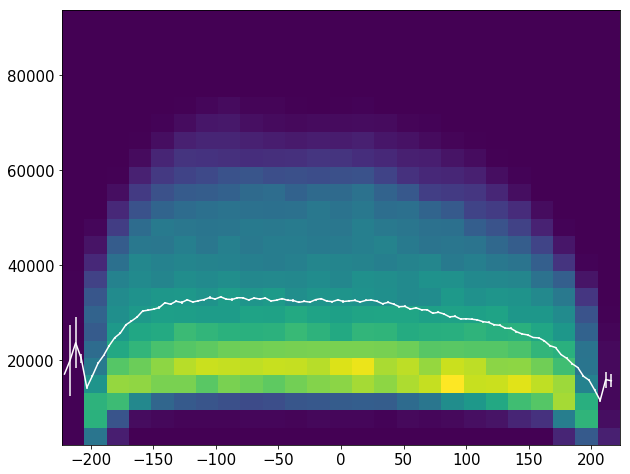

In [10]:
plt.figure(figsize=(10,8))
c = full
c = full[full.Y > -100]
c = c[c.Y <  100]
#c = c[c.Z > 100]
#plt.scatter(c.X, c.S2e)
a = fitf.profileX(c.X, c.S2e, 100)
plt.hist2d(c.X, c.S2e, bins=25)
#plt.ylim((50000,150000))
plt.errorbar(*a, c='white')
plt.show()


In [11]:
msc = full[full.S2e  >  400*units.pes * 11] # michel sorel cuts
msc = msc [msc.S1e   >   100*units.pes * 11] 
msc = msc [msc.S2w   > 3.5] # units of mus!!!
msc = msc [msc.S2w   <  25] # units of mus!!! 
msc = msc [msc.S1w   >  300*units.ns]
msc = msc [msc.S1w   < 1000*units.ns] 
msc = msc [msc.S1t   >  100*units.mus]
msc = msc [msc.S2t   <  700*units.mus]

msc = msc [msc.R     <  100*units.mm] # fidc

large_drift = full[full.DT > 530]


In [12]:
len(full)

557754

In [13]:
r = event_rate(full)

In [14]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 3.8194173264728035 evts/s


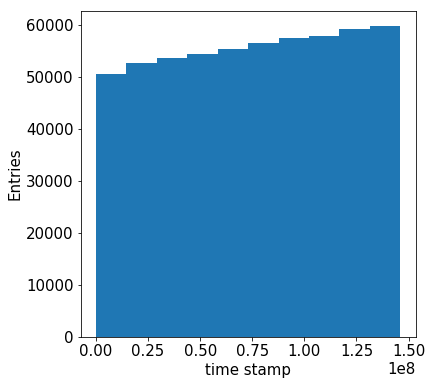

In [15]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

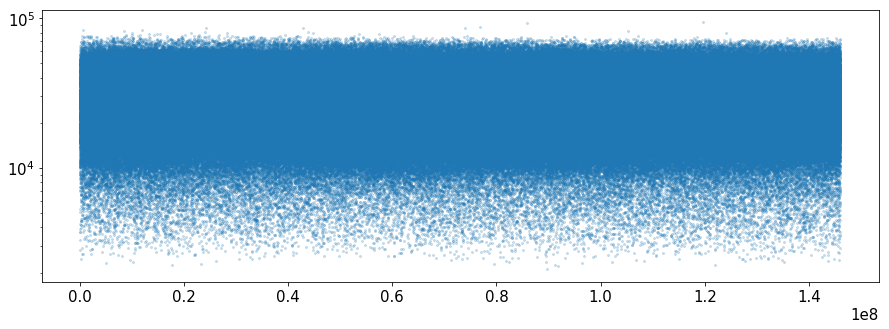

In [16]:
plt.figure(figsize=(15,5))
plt.scatter(1e+3*(full.time - full.time[0]), full.S2e, alpha=.2, s=4)
plt.yscale('log')
plt.show()

In [17]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

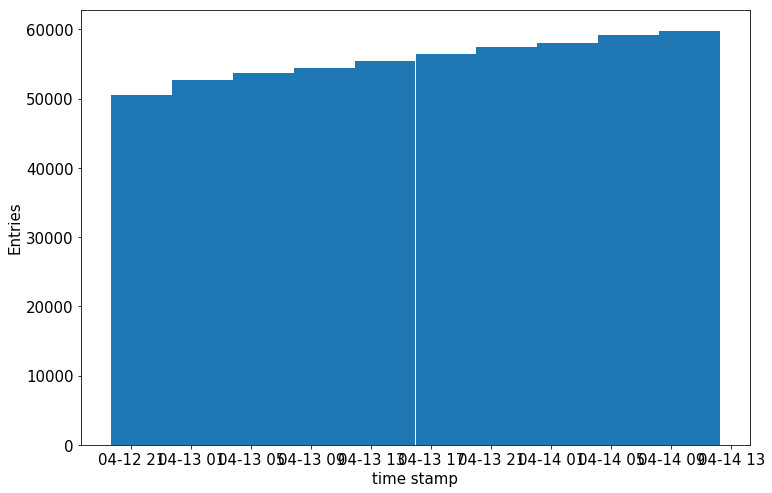

In [18]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [19]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [20]:
print(st)

2017-04-14 12:13:42


In [21]:
print(full.time.index[-1])

557753


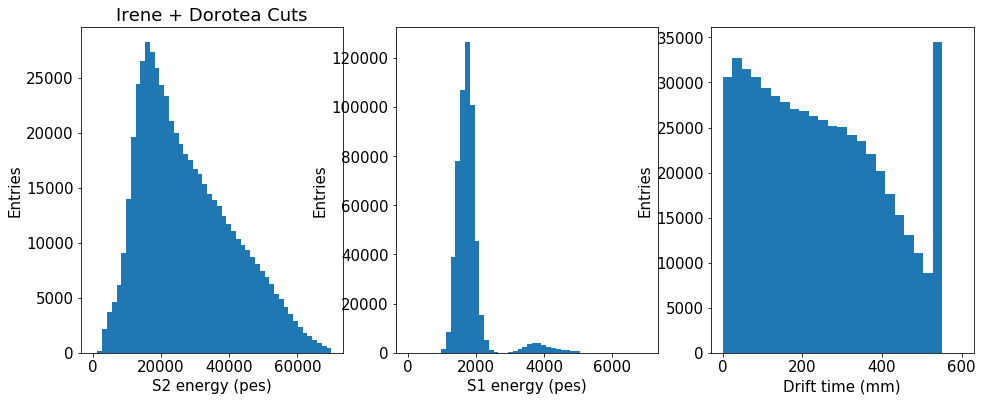

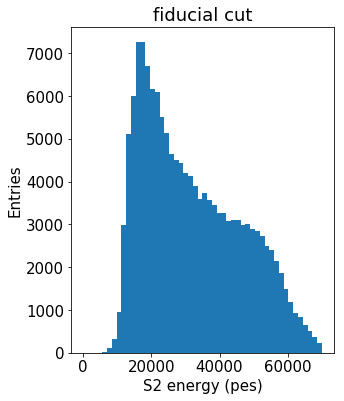

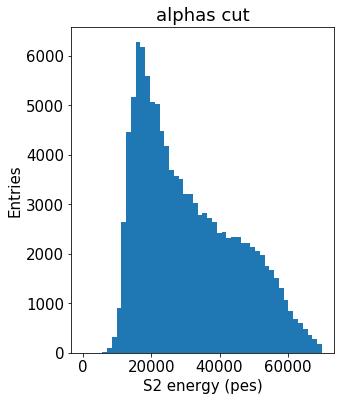

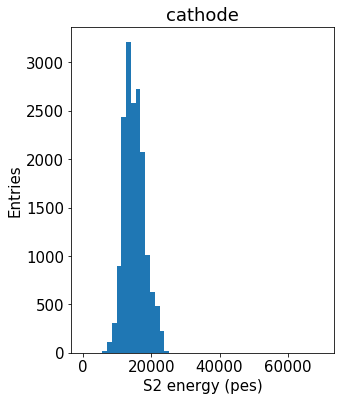

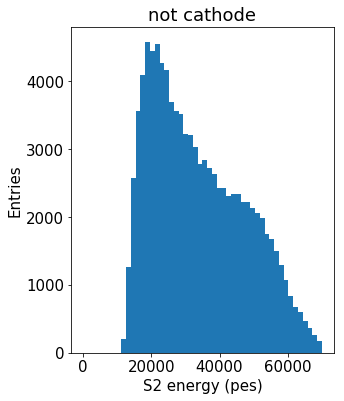

In [22]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fidc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fiducial cut')

#ax = plt.subplot(1, 3, 2)
#plt.hist(fidc.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fidc.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(msc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('alphas cut')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 2)
plt.hist(msc[in_range(msc.Z, 500, 600)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('cathode')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 3)
plt.hist(msc[in_range(msc.Z, 0, 500)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('not cathode')

#ax = plt.subplot(1, 3, 2)
#plt.hist(msc.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(msc.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

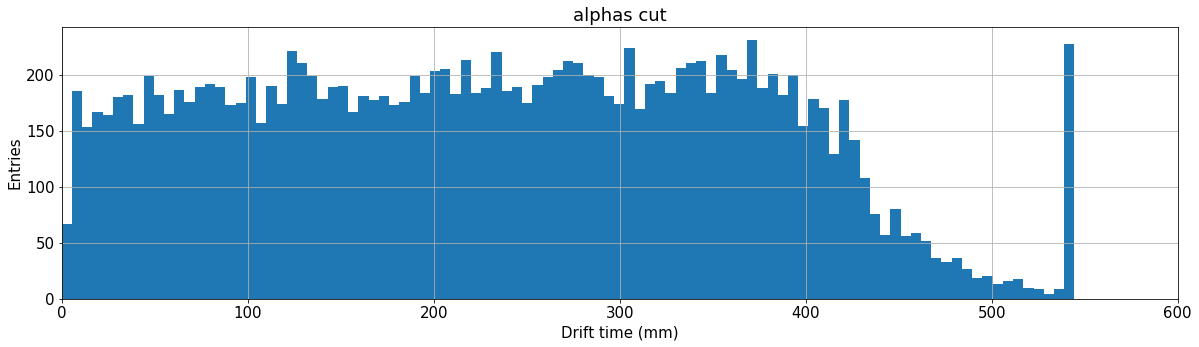

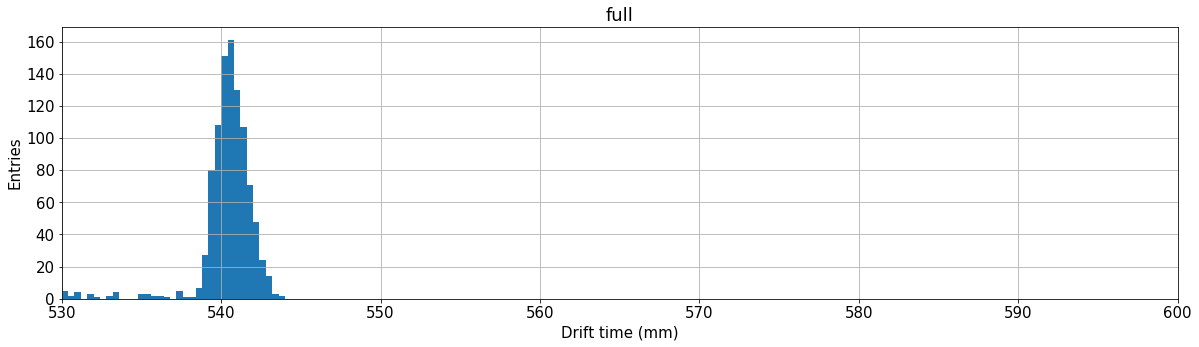

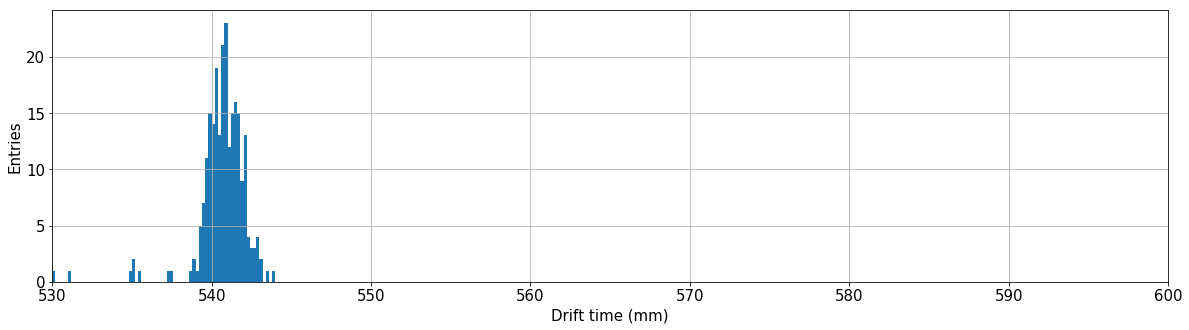

In [105]:
plt.figure(figsize=(20,5))
b = plt.hist(msc.Z, 100, (0, 550))
plt.xlim(0,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('alphas cut')




plt.figure(figsize=(20,5))
a = plt.hist(full[full.Z > 530].Z, 50, (530, 550))
plt.xlim(530,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('full')


    

plt.figure(figsize=(20,5))
b = plt.hist(msc[msc.Z > 530].Z, 100, (530, 550))
plt.xlim(530,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
#plt.title('alphas cut')



### Dependence with Z all alphas

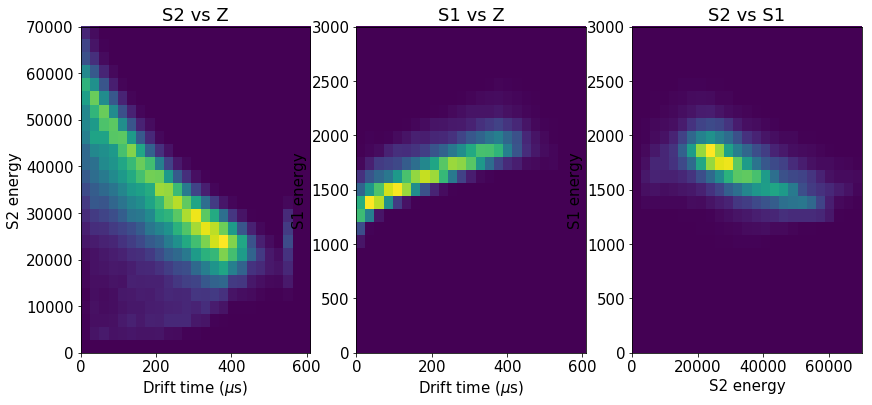

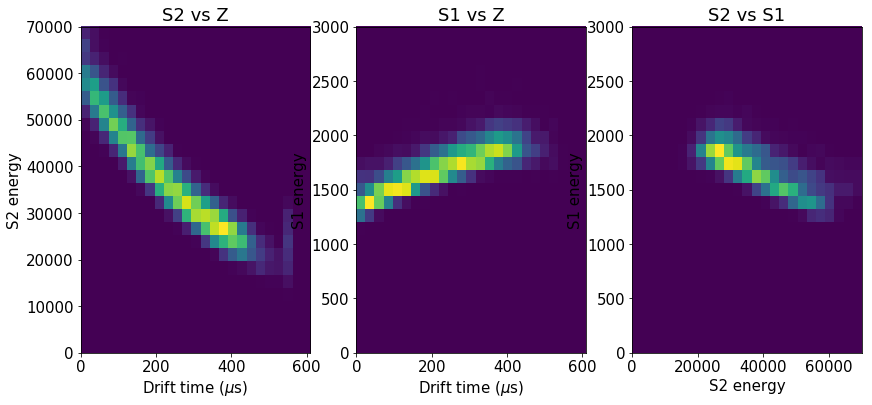

In [106]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(msc.Z, msc.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(msc.Z, msc.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(msc.S2e, msc.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [107]:
#core = blk[blk.R < 100]
core = full[full.R < 100]
print("Ratio wrt full:", len(core)/len(full))

cathode = full[full.Z > 500]
#core2 = core2[core2.Z < 500]

#core= msc

Ratio wrt full: 0.24677766977982504


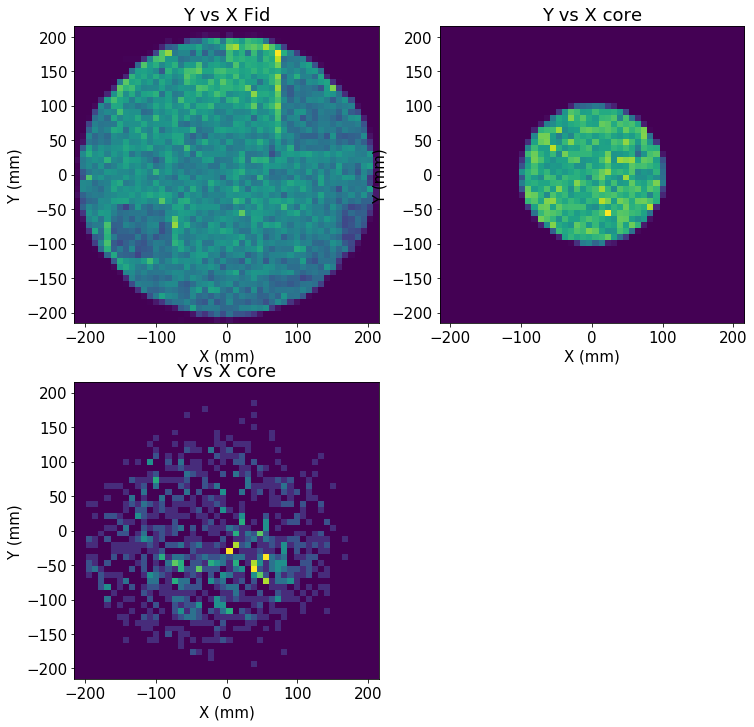

In [108]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,12)
plt.figure(figsize=figsize)
ax = plt.subplot(2, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(2, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

ax = plt.subplot(2, 2, 3)
plt.hist2d(cathode.X, cathode.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

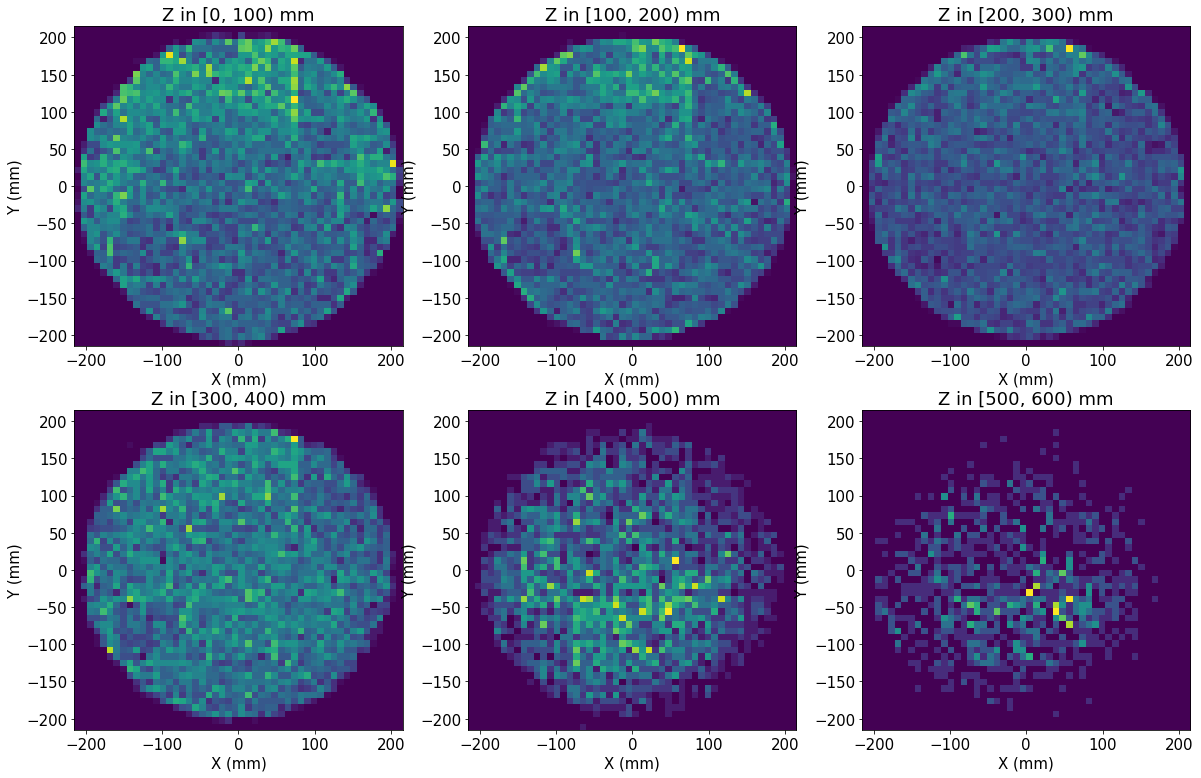

In [109]:
figsize=(20,20)
plt.figure(figsize=figsize)
ax = plt.subplot(3, 3, 1)

for i in range(6):

    ax = plt.subplot(3, 3, i+1)
    plt.hist2d(full[in_range(full.Z, i*100, (i+1)*100)].X, full[in_range(full.Z, i*100, (i+1)*100)].Y,
               (50, 50), range=(xrange, yrange))
    labels("X (mm)", "Y (mm)")
    plt.title('Z in [' + str(i*100) + ', ' + str((i+1)*100) + ') mm')

### Z correction for bulk 

#### S2

fit par[0] = 60316.320459200004 error = 142.74487884083504
fit par[1] = -456.5636050651703 error = 2.1830595963775483
degrees of freedom = 2
chi2 = 1.62741010901619


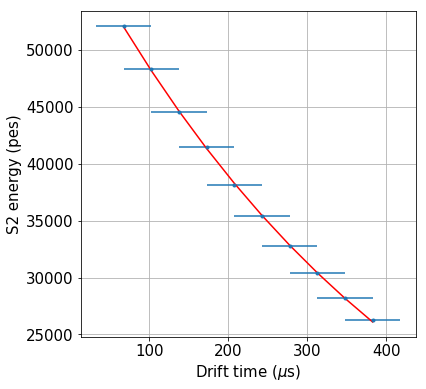

In [110]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [ ]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

#### Fit S2 in fiducial 

In [ ]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [ ]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

In [ ]:
len(cz)

In [ ]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(50,400), Erange=(1e+3, 80e3), nbins=5)

In [ ]:
plot_options()

In [ ]:
TSTAMP

In [ ]:
figsize=(15,5)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))
plt.show()



In [ ]:
plt.figure(figsize=figsize)
plt.hexbin(1e+3*(full.time - full.time[0]), full.S2e, bins=5, gridsize=70)
#plt.yscale('log')
plt.ylim(10000,70000)
#plt.ylabel('S2e')
plt.grid(True)
plt.show()

In [ ]:
print(-np.array(LAMBDA)[-2], np.array(ELAMBDA)[-2])


In [ ]:
plog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/')

pfiles = [
          plog + 'GAS_Log_2017-04-15.txt',
          plog + 'GAS_Log_2017-04-16.txt',
          plog + 'GAS_Log_2017-04-17.txt',
          plog + 'GAS_Log_2017-04-18.txt',
          plog + 'GAS_Log_2017-04-19.txt',
          plog + 'GAS_Log_2017-04-20.txt',
          plog + 'GAS_Log_2017-04-21.txt',
          plog + 'GAS_Log_2017-04-22.txt',
          plog + 'GAS_Log_2017-04-23.txt',
          plog + 'GAS_Log_2017-04-24.txt',
          plog + 'GAS_Log_2017-04-25.txt',
          plog + 'GAS_Log_2017-04-26.txt',
          plog + 'GAS_Log_2017-04-27.txt',
          plog + 'GAS_Log_2017-04-28.txt',
          plog + 'GAS_Log_2017-04-29.txt',
          plog + 'GAS_Log_2017-04-30.txt',
          plog + 'GAS_Log_2017-05-01.txt',
          plog + 'GAS_Log_2017-05-02.txt'
        ]

print(pfiles)

In [ ]:
f0 = pd.read_csv(pfiles[0], skiprows=2, sep=None, engine='python', decimal=",")
f0

In [ ]:
#f = pd.read_csv(ppath, skiprows=2, sep=None, engine='python')

T  =[]
pg3=[]
pg6=[]
for f in pfiles: 
    f = pd.read_csv(f, skiprows=2, sep=None, engine='python')

    for d, t, g3, g6 in zip(f['Date'].values, f['Hour'].values, f['PG3'].values, f['PG6'].values):
        if len(t)==7: t = '0' + t
        T.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        pg3.append(g3)
        pg6.append(g6)
    print(len(T),len(pg3))


In [ ]:
days = 30
tlog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/temperature/Data/')
tfiles = [tlog + 'PWR_Data_Report_2017-04-15.txt',
          tlog + 'PWR_Data_Report_2017-04-16.txt',
          tlog + 'PWR_Data_Report_2017-04-17.txt',
          tlog + 'PWR_Data_Report_2017-04-18.txt',
          tlog + 'PWR_Data_Report_2017-04-19.txt',
          tlog + 'PWR_Data_Report_2017-04-20.txt',
          tlog + 'PWR_Data_Report_2017-04-21.txt',
          tlog + 'PWR_Data_Report_2017-04-22.txt',
          tlog + 'PWR_Data_Report_2017-04-23.txt',
          tlog + 'PWR_Data_Report_2017-04-24.txt',
          tlog + 'PWR_Data_Report_2017-04-25.txt',
          tlog + 'PWR_Data_Report_2017-04-26.txt',
          tlog + 'PWR_Data_Report_2017-04-27.txt',
          tlog + 'PWR_Data_Report_2017-04-28.txt',
          tlog + 'PWR_Data_Report_2017-04-29.txt',
          tlog + 'PWR_Data_Report_2017-04-30.txt',
          tlog + 'PWR_Data_Report_2017-05-01.txt',
          tlog + 'PWR_Data_Report_2017-05-02.txt']

In [ ]:
f0 = pd.read_csv(tfiles[0], skiprows=2, sep='\s+', engine='python')
f0

In [ ]:
tfiles

In [ ]:
Tt=[]
dbs=[]
for f in tfiles: 
    f = pd.read_csv(f, skiprows=2, sep='\s+', engine='python')

    for i, (d, t) in enumerate(zip(f['Date'].values, f['Hour'].values)):
        if len(t)==7: t = '0' + t
        Tt.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        dbs.append([f['DB1_Temp(�C)'][i],  f['DB2_Temp(�C)'] [i], f['DB3_Temp(�C)'] [i],
                    f['DB4_Temp(�C)'][i],  f['DB5_Temp(�C)'] [i], f['DB6_Temp(�C)'] [i],
                    f['DB7_Temp(�C)'][i],  f['DB8_Temp(�C)'] [i], f['DB9_Temp(�C)'] [i],
                    f['DB10_Temp(�C)'][i], f['DB11_Temp(�C)'][i], f['DB12_Temp(�C)'][i],
                    f['DB13_Temp(�C)'][i], f['DB14_Temp(�C)'][i], f['DB15_Temp(�C)'][i],
                    f['DB16_Temp(�C)'][i], f['DB17_Temp(�C)'][i], f['DB18_Temp(�C)'][i],
                    f['DB19_Temp(�C)'][i], f['DB20_Temp(�C)'][i], f['DB21_Temp(�C)'][i],
                    f['DB22_Temp(�C)'][i], f['DB23_Temp(�C)'][i], f['DB24_Temp(�C)'][i],
                    f['DB25_Temp(�C)'][i], f['DB26_Temp(�C)'][i], f['DB27_Temp(�C)'][i],
                    f['DB28_Temp(�C)'][i]])

In [ ]:
fig, ax1 = plt.subplots(figsize=(40, 10))

#plt.legend(loc=2)
ax1.plot(Tt, dbs)
ax1.set_ylabel('Temperature (C)')
ax2=ax1.twinx()
ax2.plot(T, [float(v.replace(',','.')) for v in pg3],alpha=.8)
ax2.set_ylabel('Pressure (bar)')
plt.title('DB temperatures and PG3')
plt.grid(True)
plt.show()

In [ ]:
np.array([float(v.replace(',','.')) for v in pg3])